# Steam Game Recommendation System - Exploratory Data Analysis

## Project Overview
This notebook performs exploratory data analysis on Steam game purchase data to build a recommendation system that:
1. **Predicts next-game purchases** based on user history
2. **Recommends bundle completion** for partially owned bundles
3. **Discovers cross-bundle similarities** for themed game collections

**Key Hypothesis**: Games sold together in bundles provide stronger recommendation signals than traditional collaborative filtering.

**Dataset**: UCSD Steam Dataset - https://cseweb.ucsd.edu/~jmcauley/datasets.html#steam_data

## 1. Download and Extract Dataset

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import gzip
import urllib.request
import os
from collections import Counter, defaultdict
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [13]:
# # Create data directory
data_dir = '/Users/mvaishak/Developer/Homeworks & Assignments/CSE258R Recommender Systems & Web Mining/Assignment 2/PlayNext/data'
os.makedirs(data_dir, exist_ok=True)

# # Dataset URLs from UCSD Steam Data
urls = {
    'games': 'https://cseweb.ucsd.edu/~jmcauley/datasets/steam/steam_games.json.gz',
    'reviews': 'https://cseweb.ucsd.edu/~jmcauley/datasets/steam/australian_users_items.json.gz',
    'bundles': 'https://cseweb.ucsd.edu/~jmcauley/datasets/steam/bundle_data.json.gz'
}

# # Download function
def download_file(url, filename):
    filepath = os.path.join(data_dir, filename)
    if os.path.exists(filepath):
        print(f"✓ {filename} already exists")
        return filepath
    
    print(f"Downloading {filename}...")
    try:
        urllib.request.urlretrieve(url, filepath)
        print(f"✓ Downloaded {filename} ({os.path.getsize(filepath) / 1e6:.1f} MB)")
        return filepath
    except Exception as e:
        print(f"✗ Error downloading {filename}: {e}")
        return None

# # Download all datasets
# print("=" * 60)
# print("DOWNLOADING STEAM DATASETS")
# print("=" * 60)

downloaded_files = {}
for name, url in urls.items():
    filename = url.split('/')[-1]
    filepath = os.path.join(data_dir, filename)
    if filepath:
        downloaded_files[name] = filepath

# print("\n" + "=" * 60)
# print(f"Downloaded {len(downloaded_files)}/{len(urls)} files successfully")
# print("=" * 60)

## 2. Load and Inspect Data Files

In [19]:
# Function to load gzipped JSON files
import ast

def load_json_gz(filepath, max_lines=None):
    """Load JSON lines from gzipped file"""
    data = []
    with gzip.open(filepath, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if max_lines and i >= max_lines:
                break
            try:
                # First try standard JSON parsing
                data.append(json.loads(line))
            except json.JSONDecodeError:
                try:
                    # If that fails, try Python literal eval (for Python 2 format with u'...')
                    data.append(ast.literal_eval(line))
                except (ValueError, SyntaxError):
                    # Skip lines that can't be parsed
                    continue
    return data

print("Loading datasets (this may take a few minutes)...")
print("-" * 60)

# Load games data
if 'games' in downloaded_files:
    print("Loading games data...")
    games_data = load_json_gz(downloaded_files['games'])
    games_df = pd.DataFrame(games_data)
    print(f"✓ Loaded {len(games_df):,} games")

# Load user-item interactions (reviews/purchases)
if 'reviews' in downloaded_files:
    print("Loading user purchase data...")
    users_data = load_json_gz(downloaded_files['reviews'])
    print(f"✓ Loaded {len(users_data):,} user records")

# Load bundle data
if 'bundles' in downloaded_files:
    print("Loading bundle data...")
    bundles_data = load_json_gz(downloaded_files['bundles'])
    bundles_df = pd.DataFrame(bundles_data)
    print(f"✓ Loaded {len(bundles_df):,} bundles")

print("-" * 60)
print("All datasets loaded successfully!")

Loading datasets (this may take a few minutes)...
------------------------------------------------------------
Loading games data...
✓ Loaded 32,135 games
Loading user purchase data...
✓ Loaded 32,135 games
Loading user purchase data...
✓ Loaded 88,310 user records
Loading bundle data...
✓ Loaded 615 bundles
------------------------------------------------------------
All datasets loaded successfully!
✓ Loaded 88,310 user records
Loading bundle data...
✓ Loaded 615 bundles
------------------------------------------------------------
All datasets loaded successfully!


In [20]:
# Inspect games data structure
print("=" * 60)
print("GAMES DATA STRUCTURE")
print("=" * 60)
print(f"Shape: {games_df.shape}")
print(f"\nColumns: {list(games_df.columns)}")
print(f"\nSample record:")
print(games_df.head(3))

GAMES DATA STRUCTURE
Shape: (32135, 16)

Columns: ['publisher', 'genres', 'app_name', 'title', 'url', 'release_date', 'tags', 'discount_price', 'reviews_url', 'specs', 'price', 'early_access', 'id', 'developer', 'sentiment', 'metascore']

Sample record:
          publisher                                             genres  \
0         Kotoshiro      [Action, Casual, Indie, Simulation, Strategy]   
1  Making Fun, Inc.               [Free to Play, Indie, RPG, Strategy]   
2      Poolians.com  [Casual, Free to Play, Indie, Simulation, Sports]   

                  app_name                    title  \
0      Lost Summoner Kitty      Lost Summoner Kitty   
1                Ironbound                Ironbound   
2  Real Pool 3D - Poolians  Real Pool 3D - Poolians   

                                                 url release_date  \
0  http://store.steampowered.com/app/761140/Lost_...   2018-01-04   
1  http://store.steampowered.com/app/643980/Ironb...   2018-01-04   
2  http://store.steam

In [21]:
# Inspect user purchase data structure
print("=" * 60)
print("USER PURCHASE DATA STRUCTURE")
print("=" * 60)
print(f"Number of users: {len(users_data):,}")
print(f"\nSample user record:")
if users_data:
    sample_user = users_data[0]
    print(f"User ID: {sample_user.get('user_id', 'N/A')}")
    print(f"Number of items: {len(sample_user.get('items', []))}")
    print(f"\nSample items (first 3):")
    for i, item in enumerate(sample_user.get('items', [])[:3]):
        print(f"  {i+1}. {item}")

USER PURCHASE DATA STRUCTURE
Number of users: 88,310

Sample user record:
User ID: 76561197970982479
Number of items: 277

Sample items (first 3):
  1. {'item_id': '10', 'item_name': 'Counter-Strike', 'playtime_forever': 6, 'playtime_2weeks': 0}
  2. {'item_id': '20', 'item_name': 'Team Fortress Classic', 'playtime_forever': 0, 'playtime_2weeks': 0}
  3. {'item_id': '30', 'item_name': 'Day of Defeat', 'playtime_forever': 7, 'playtime_2weeks': 0}


In [22]:
# Inspect bundle data structure
print("=" * 60)
print("BUNDLE DATA STRUCTURE")
print("=" * 60)
print(f"Shape: {bundles_df.shape}")
print(f"\nColumns: {list(bundles_df.columns)}")
print(f"\nSample bundles:")
print(bundles_df.head(3))

BUNDLE DATA STRUCTURE
Shape: (615, 7)

Columns: ['bundle_final_price', 'bundle_url', 'bundle_price', 'bundle_name', 'bundle_id', 'items', 'bundle_discount']

Sample bundles:
  bundle_final_price                                         bundle_url  \
0             $66.46  http://store.steampowered.com/bundle/450/?utm_...   
1             $20.15  http://store.steampowered.com/bundle/1473/?utm...   
2             $20.15  http://store.steampowered.com/bundle/1474/?utm...   

  bundle_price                              bundle_name bundle_id  \
0       $73.86             Dharker Studio 2015 Complete       450   
1       $25.87  Naruto Shippuden Uncut Season 4, Vol. 3      1473   
2       $25.87  Naruto Shippuden Uncut Season 4, Vol. 4      1474   

                                               items bundle_discount  
0  [{'genre': 'Adventure, Indie, RPG', 'item_id':...             10%  
1  [{'genre': '', 'item_id': '528360', 'discounte...             22%  
2  [{'genre': '', 'item_id': '52838

## 3. Explore User Purchase History

In [23]:
# Analyze user purchase patterns
games_per_user = [len(user.get('items', [])) for user in users_data]

print("=" * 60)
print("USER PURCHASE STATISTICS")
print("=" * 60)
print(f"Total users: {len(users_data):,}")
print(f"\nGames per user:")
print(f"  Mean: {np.mean(games_per_user):.2f}")
print(f"  Median: {np.median(games_per_user):.2f}")
print(f"  Min: {np.min(games_per_user)}")
print(f"  Max: {np.max(games_per_user)}")
print(f"  Std: {np.std(games_per_user):.2f}")

# Quartiles
quartiles = np.percentile(games_per_user, [25, 50, 75, 90, 95, 99])
print(f"\nPercentiles:")
for p, q in zip([25, 50, 75, 90, 95, 99], quartiles):
    print(f"  {p}th: {q:.0f} games")

# User categories
casual_users = sum(1 for g in games_per_user if g <= 10)
moderate_users = sum(1 for g in games_per_user if 10 < g <= 50)
power_users = sum(1 for g in games_per_user if g > 50)

print(f"\nUser Categories:")
print(f"  Casual (≤10 games): {casual_users:,} ({casual_users/len(users_data)*100:.1f}%)")
print(f"  Moderate (11-50 games): {moderate_users:,} ({moderate_users/len(users_data)*100:.1f}%)")
print(f"  Power (>50 games): {power_users:,} ({power_users/len(users_data)*100:.1f}%)")

USER PURCHASE STATISTICS
Total users: 88,310

Games per user:
  Mean: 58.35
  Median: 26.00
  Min: 0
  Max: 7762
  Std: 122.31

Percentiles:
  25th: 3 games
  50th: 26 games
  75th: 73 games
  90th: 143 games
  95th: 211 games
  99th: 437 games

User Categories:
  Casual (≤10 games): 31,361 (35.5%)
  Moderate (11-50 games): 26,416 (29.9%)
  Power (>50 games): 30,533 (34.6%)


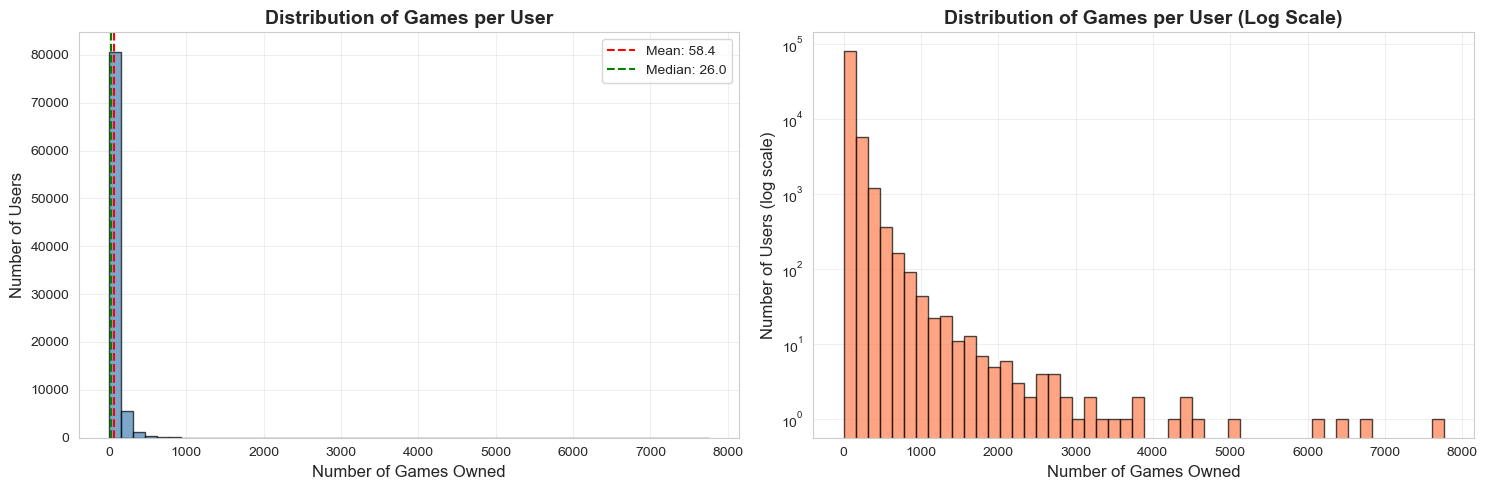

In [24]:
# Visualize distribution of games per user
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram with bins
axes[0].hist(games_per_user, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Number of Games Owned', fontsize=12)
axes[0].set_ylabel('Number of Users', fontsize=12)
axes[0].set_title('Distribution of Games per User', fontsize=14, fontweight='bold')
axes[0].axvline(np.mean(games_per_user), color='red', linestyle='--', label=f'Mean: {np.mean(games_per_user):.1f}')
axes[0].axvline(np.median(games_per_user), color='green', linestyle='--', label=f'Median: {np.median(games_per_user):.1f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Log scale version to see tail
axes[1].hist(games_per_user, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Number of Games Owned', fontsize=12)
axes[1].set_ylabel('Number of Users (log scale)', fontsize=12)
axes[1].set_title('Distribution of Games per User (Log Scale)', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Analyze Bundle Relationships

In [25]:
# Analyze bundle structure
print("=" * 60)
print("BUNDLE ANALYSIS")
print("=" * 60)
print(f"Total bundles: {len(bundles_df):,}")
print(f"\nBundle columns: {list(bundles_df.columns)}")

# Check if bundles have items/apps
if 'items' in bundles_df.columns:
    bundle_sizes = bundles_df['items'].apply(lambda x: len(x) if isinstance(x, list) else 0)
elif 'apps' in bundles_df.columns:
    bundle_sizes = bundles_df['apps'].apply(lambda x: len(x) if isinstance(x, list) else 0)
else:
    # Try to find the column with game items
    for col in bundles_df.columns:
        sample_val = bundles_df[col].iloc[0]
        if isinstance(sample_val, list):
            bundle_sizes = bundles_df[col].apply(lambda x: len(x) if isinstance(x, list) else 0)
            print(f"Using column '{col}' for bundle items")
            break

print(f"\nGames per bundle:")
print(f"  Mean: {bundle_sizes.mean():.2f}")
print(f"  Median: {bundle_sizes.median():.2f}")
print(f"  Min: {bundle_sizes.min()}")
print(f"  Max: {bundle_sizes.max()}")
print(f"  Std: {bundle_sizes.std():.2f}")

print(f"\nBundle size distribution:")
size_dist = bundle_sizes.value_counts().sort_index().head(10)
for size, count in size_dist.items():
    print(f"  {size} games: {count:,} bundles")

BUNDLE ANALYSIS
Total bundles: 615

Bundle columns: ['bundle_final_price', 'bundle_url', 'bundle_price', 'bundle_name', 'bundle_id', 'items', 'bundle_discount']

Games per bundle:
  Mean: 5.73
  Median: 3.00
  Min: 2
  Max: 89
  Std: 8.01

Bundle size distribution:
  2 games: 231 bundles
  3 games: 103 bundles
  4 games: 86 bundles
  5 games: 45 bundles
  6 games: 22 bundles
  7 games: 22 bundles
  8 games: 12 bundles
  9 games: 15 bundles
  10 games: 7 bundles
  11 games: 6 bundles


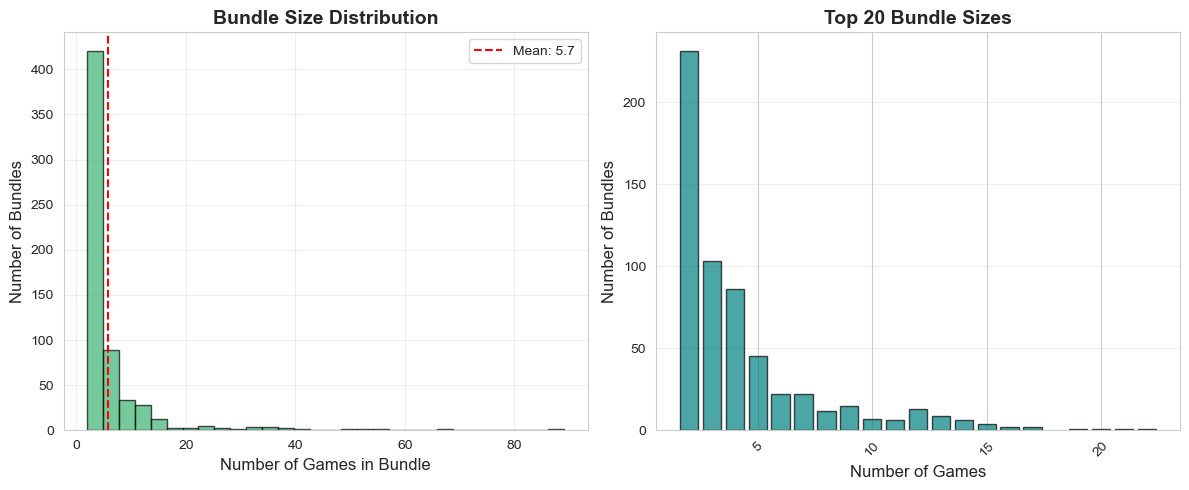

In [26]:
# Visualize bundle size distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(bundle_sizes, bins=30, edgecolor='black', alpha=0.7, color='mediumseagreen')
plt.xlabel('Number of Games in Bundle', fontsize=12)
plt.ylabel('Number of Bundles', fontsize=12)
plt.title('Bundle Size Distribution', fontsize=14, fontweight='bold')
plt.axvline(bundle_sizes.mean(), color='red', linestyle='--', label=f'Mean: {bundle_sizes.mean():.1f}')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
size_counts = bundle_sizes.value_counts().sort_index().head(20)
plt.bar(size_counts.index, size_counts.values, color='teal', alpha=0.7, edgecolor='black')
plt.xlabel('Number of Games', fontsize=12)
plt.ylabel('Number of Bundles', fontsize=12)
plt.title('Top 20 Bundle Sizes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Temporal Analysis of Purchases

In [27]:
# Extract playtime and purchase information
all_items = []
for user in users_data:
    user_id = user.get('user_id', 'unknown')
    for item in user.get('items', []):
        item_copy = item.copy()
        item_copy['user_id'] = user_id
        all_items.append(item_copy)

items_df = pd.DataFrame(all_items)

print("=" * 60)
print("ITEM INTERACTION DATA")
print("=" * 60)
print(f"Total user-game interactions: {len(items_df):,}")
print(f"\nColumns: {list(items_df.columns)}")
print(f"\nSample interactions:")
print(items_df.head())

ITEM INTERACTION DATA
Total user-game interactions: 5,153,209

Columns: ['item_id', 'item_name', 'playtime_forever', 'playtime_2weeks', 'user_id']

Sample interactions:
  item_id                  item_name  playtime_forever  playtime_2weeks  \
0      10             Counter-Strike                 6                0   
1      20      Team Fortress Classic                 0                0   
2      30              Day of Defeat                 7                0   
3      40         Deathmatch Classic                 0                0   
4      50  Half-Life: Opposing Force                 0                0   

             user_id  
0  76561197970982479  
1  76561197970982479  
2  76561197970982479  
3  76561197970982479  
4  76561197970982479  


In [28]:
# Analyze playtime data
if 'playtime_forever' in items_df.columns:
    print("\n" + "=" * 60)
    print("PLAYTIME ANALYSIS")
    print("=" * 60)
    
    playtime_hours = items_df['playtime_forever'] / 60  # Convert minutes to hours
    
    print(f"Playtime statistics (hours):")
    print(f"  Mean: {playtime_hours.mean():.2f}")
    print(f"  Median: {playtime_hours.median():.2f}")
    print(f"  Max: {playtime_hours.max():.2f}")
    
    # Games with zero playtime (purchased but never played)
    never_played = (items_df['playtime_forever'] == 0).sum()
    print(f"\nGames never played: {never_played:,} ({never_played/len(items_df)*100:.1f}%)")
    
    # Playtime categories
    no_play = (playtime_hours == 0).sum()
    light_play = ((playtime_hours > 0) & (playtime_hours <= 10)).sum()
    moderate_play = ((playtime_hours > 10) & (playtime_hours <= 100)).sum()
    heavy_play = (playtime_hours > 100).sum()
    
    print(f"\nPlaytime categories:")
    print(f"  Never played: {no_play:,} ({no_play/len(items_df)*100:.1f}%)")
    print(f"  Light (≤10h): {light_play:,} ({light_play/len(items_df)*100:.1f}%)")
    print(f"  Moderate (10-100h): {moderate_play:,} ({moderate_play/len(items_df)*100:.1f}%)")
    print(f"  Heavy (>100h): {heavy_play:,} ({heavy_play/len(items_df)*100:.1f}%)")


PLAYTIME ANALYSIS
Playtime statistics (hours):
  Mean: 16.52
  Median: 0.57
  Max: 10712.88

Games never played: 1,867,963 (36.2%)

Playtime categories:
  Never played: 1,867,963 (36.2%)
  Light (≤10h): 2,301,330 (44.7%)
  Moderate (10-100h): 818,933 (15.9%)
  Heavy (>100h): 164,983 (3.2%)


## 6. Visualize Game Popularity Distribution

In [29]:
# Analyze game popularity
item_id_col = 'item_id' if 'item_id' in items_df.columns else 'app_id' if 'app_id' in items_df.columns else items_df.columns[0]
game_popularity = items_df[item_id_col].value_counts()

print("=" * 60)
print("GAME POPULARITY ANALYSIS")
print("=" * 60)
print(f"Unique games: {len(game_popularity):,}")
print(f"Total ownership records: {game_popularity.sum():,}")
print(f"\nMost popular games (top 20):")
for i, (game_id, count) in enumerate(game_popularity.head(20).items(), 1):
    print(f"  {i}. Game {game_id}: {count:,} owners")

print(f"\nPopularity distribution:")
print(f"  Mean owners per game: {game_popularity.mean():.2f}")
print(f"  Median owners per game: {game_popularity.median():.2f}")
print(f"  Max owners: {game_popularity.max():,}")
print(f"  Min owners: {game_popularity.min():,}")

# Long tail analysis
top_10_pct = int(len(game_popularity) * 0.1)
top_games_ownership = game_popularity.head(top_10_pct).sum()
print(f"\nLong-tail analysis:")
print(f"  Top 10% games ({top_10_pct:,} games) account for {top_games_ownership/game_popularity.sum()*100:.1f}% of all ownership")

GAME POPULARITY ANALYSIS
Unique games: 10,978
Total ownership records: 5,153,209

Most popular games (top 20):
  1. Game 205790: 49,571 owners
  2. Game 730: 43,776 owners
  3. Game 4000: 43,301 owners
  4. Game 304930: 38,682 owners
  5. Game 223530: 37,044 owners
  6. Game 550: 37,044 owners
  7. Game 105600: 29,239 owners
  8. Game 230410: 25,807 owners
  9. Game 620: 24,465 owners
  10. Game 240: 24,220 owners
  11. Game 218620: 23,729 owners
  12. Game 72850: 22,285 owners
  13. Game 301520: 21,785 owners
  14. Game 49520: 21,029 owners
  15. Game 218230: 20,726 owners
  16. Game 340: 19,826 owners
  17. Game 227940: 19,721 owners
  18. Game 400: 18,774 owners
  19. Game 220: 18,307 owners
  20. Game 236390: 18,172 owners

Popularity distribution:
  Mean owners per game: 469.41
  Median owners per game: 43.00
  Max owners: 49,571
  Min owners: 1

Long-tail analysis:
  Top 10% games (1,097 games) account for 78.3% of all ownership


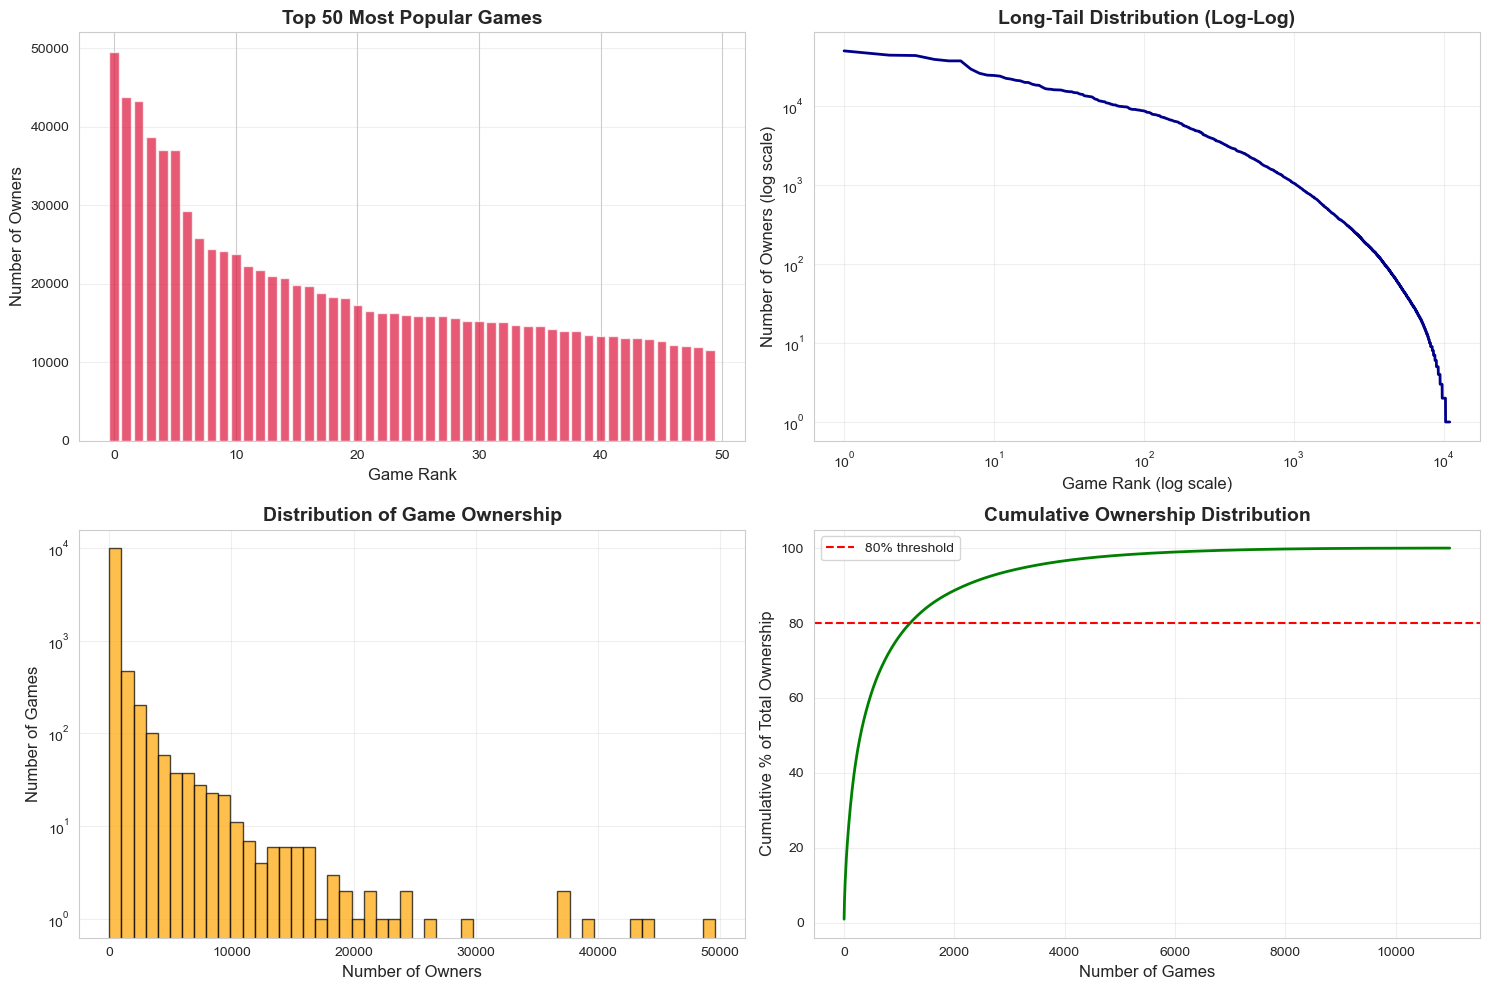

In [30]:
# Visualize game popularity distribution (long-tail)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Top 50 games
axes[0, 0].bar(range(50), game_popularity.head(50).values, color='crimson', alpha=0.7)
axes[0, 0].set_xlabel('Game Rank', fontsize=12)
axes[0, 0].set_ylabel('Number of Owners', fontsize=12)
axes[0, 0].set_title('Top 50 Most Popular Games', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='y')

# Full distribution (log-log scale)
axes[0, 1].loglog(range(1, len(game_popularity) + 1), game_popularity.values, color='darkblue', linewidth=2)
axes[0, 1].set_xlabel('Game Rank (log scale)', fontsize=12)
axes[0, 1].set_ylabel('Number of Owners (log scale)', fontsize=12)
axes[0, 1].set_title('Long-Tail Distribution (Log-Log)', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Histogram of ownership counts
axes[1, 0].hist(game_popularity.values, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Number of Owners', fontsize=12)
axes[1, 0].set_ylabel('Number of Games', fontsize=12)
axes[1, 0].set_title('Distribution of Game Ownership', fontsize=14, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(alpha=0.3)

# Cumulative distribution
cumsum = game_popularity.sort_values(ascending=False).cumsum()
cumsum_pct = cumsum / cumsum.iloc[-1] * 100
axes[1, 1].plot(range(len(cumsum_pct)), cumsum_pct.values, color='green', linewidth=2)
axes[1, 1].set_xlabel('Number of Games', fontsize=12)
axes[1, 1].set_ylabel('Cumulative % of Total Ownership', fontsize=12)
axes[1, 1].set_title('Cumulative Ownership Distribution', fontsize=14, fontweight='bold')
axes[1, 1].axhline(80, color='red', linestyle='--', label='80% threshold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Examine Bundle Co-occurrence Patterns

In [31]:
# Analyze game co-occurrence in user libraries
from itertools import combinations

print("=" * 60)
print("GAME CO-OCCURRENCE ANALYSIS")
print("=" * 60)
print("Calculating co-occurrence matrix (this may take a moment)...")

# Build co-occurrence matrix for top games (to keep it manageable)
top_n_games = 100
top_games = game_popularity.head(top_n_games).index.tolist()

# Count co-occurrences
co_occurrence = defaultdict(int)
for user in users_data[:1000]:  # Sample first 1000 users for speed
    user_games = [item.get(item_id_col) for item in user.get('items', [])]
    user_games = [g for g in user_games if g in top_games]
    
    # Count pairs
    for game1, game2 in combinations(sorted(user_games), 2):
        co_occurrence[(game1, game2)] += 1

# Convert to list and sort
co_occurrence_list = [(pair, count) for pair, count in co_occurrence.items()]
co_occurrence_list.sort(key=lambda x: x[1], reverse=True)

print(f"\nTotal co-occurrence pairs: {len(co_occurrence_list):,}")
print(f"\nTop 20 game pairs that appear together:")
for i, ((game1, game2), count) in enumerate(co_occurrence_list[:20], 1):
    print(f"  {i}. Game {game1} & Game {game2}: {count:,} users")

GAME CO-OCCURRENCE ANALYSIS
Calculating co-occurrence matrix (this may take a moment)...

Total co-occurrence pairs: 4,950

Top 20 game pairs that appear together:
  1. Game 4000 & Game 730: 586 users
  2. Game 205790 & Game 730: 551 users
  3. Game 223530 & Game 550: 537 users
  4. Game 304930 & Game 730: 525 users
  5. Game 304930 & Game 4000: 517 users
  6. Game 205790 & Game 4000: 506 users
  7. Game 223530 & Game 730: 476 users
  8. Game 550 & Game 730: 476 users
  9. Game 205790 & Game 304930: 471 users
  10. Game 223530 & Game 4000: 454 users
  11. Game 4000 & Game 550: 454 users
  12. Game 205790 & Game 223530: 439 users
  13. Game 205790 & Game 550: 439 users
  14. Game 105600 & Game 4000: 436 users
  15. Game 105600 & Game 730: 424 users
  16. Game 223530 & Game 304930: 404 users
  17. Game 304930 & Game 550: 404 users
  18. Game 230410 & Game 730: 398 users
  19. Game 205790 & Game 230410: 396 users
  20. Game 105600 & Game 205790: 393 users


In [38]:
# Analyze which games appear in bundles
bundle_item_col = None
for col in bundles_df.columns:
    sample_val = bundles_df[col].iloc[0]
    if isinstance(sample_val, list):
        bundle_item_col = col
        break

if bundle_item_col:
    print("\n" + "=" * 60)
    print("BUNDLE COMPOSITION ANALYSIS")
    print("=" * 60)
    
    # Count how many bundles each game appears in
    game_bundle_count = defaultdict(int)
    for bundle_items in bundles_df[bundle_item_col]:
        if isinstance(bundle_items, list):
            for game in bundle_items:
                game_bundle_count[game['item_name']] += 1
    
    # Convert to sorted list
    game_bundle_freq = sorted(game_bundle_count.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nGames appearing in multiple bundles (top 20):")
    for i, (game, count) in enumerate(game_bundle_freq[:20], 1):
        print(f"  {i}. Game {game}: appears in {count} bundles")
    
    # Distribution of bundle appearances
    bundle_counts = list(game_bundle_count.values())
    print(f"\nBundle appearance statistics:")
    print(f"  Mean bundles per game: {np.mean(bundle_counts):.2f}")
    print(f"  Median bundles per game: {np.median(bundle_counts):.2f}")
    print(f"  Max bundles: {max(bundle_counts)}")
    
    # Games in only one bundle vs multiple
    single_bundle = sum(1 for c in bundle_counts if c == 1)
    multi_bundle = sum(1 for c in bundle_counts if c > 1)
    print(f"\n  Games in only 1 bundle: {single_bundle:,} ({single_bundle/len(bundle_counts)*100:.1f}%)")
    print(f"  Games in multiple bundles: {multi_bundle:,} ({multi_bundle/len(bundle_counts)*100:.1f}%)")


BUNDLE COMPOSITION ANALYSIS

Games appearing in multiple bundles (top 20):
  1. Game Steam Controller: appears in 7 bundles
  2. Game Puzzle Box: appears in 6 bundles
  3. Game Dyna Bomb: appears in 6 bundles
  4. Game Genius Greedy Mouse: appears in 5 bundles
  5. Game Go Mission: Space Travel: appears in 5 bundles
  6. Game 1917 - The Alien Invasion: appears in 5 bundles
  7. Game Bibou: appears in 5 bundles
  8. Game Ghost Sweeper: appears in 5 bundles
  9. Game Kabitis: appears in 5 bundles
  10. Game F1 2016: appears in 4 bundles
  11. Game Karma Miwa: appears in 4 bundles
  12. Game Neon Warp: appears in 4 bundles
  13. Game Totally Unbalanced: appears in 4 bundles
  14. Game Airscape - The Fall of Gravity: appears in 4 bundles
  15. Game Rolling Sun: appears in 4 bundles
  16. Game Battle Ranch: Pigs vs Plants: appears in 4 bundles
  17. Game Spakoyno: Back to the USSR 2.0: appears in 4 bundles
  18. Game Spakoyno: Back To USSR 2.0 - OST: appears in 4 bundles
  19. Game Choice 

## 8. Identify Data Quality Issues

In [40]:
# Check data quality issues
print("=" * 60)
print("DATA QUALITY ASSESSMENT")
print("=" * 60)

# Games data
print("\nGAMES DATA:")
print(f"  Total records: {len(games_df):,}")
print(f"  Missing values per column:")
for col in games_df.columns:
    missing = games_df[col].isna().sum()
    if missing > 0:
        print(f"    {col}: {missing:,} ({missing/len(games_df)*100:.1f}%)")

# Items/purchases data
print("\nUSER PURCHASE DATA:")
print(f"  Total records: {len(items_df):,}")
print(f"  Missing values per column:")
for col in items_df.columns:
    missing = items_df[col].isna().sum()
    if missing > 0:
        print(f"    {col}: {missing:,} ({missing/len(items_df)*100:.1f}%)")

# Check for duplicates
duplicate_users = len(users_data) - len(set(u.get('user_id') for u in users_data))
print(f"\n  Duplicate user IDs: {duplicate_users}")

# Bundles data
print("\nBUNDLE DATA:")
print(f"  Total records: {len(bundles_df):,}")
print(f"  Missing values per column:")
for col in bundles_df.columns:
    missing = bundles_df[col].isna().sum()
    if missing > 0:
        print(f"    {col}: {missing:,} ({missing/len(bundles_df)*100:.1f}%)")

DATA QUALITY ASSESSMENT

GAMES DATA:
  Total records: 32,135
  Missing values per column:
    publisher: 8,052 (25.1%)
    genres: 3,283 (10.2%)
    app_name: 2 (0.0%)
    title: 2,050 (6.4%)
    release_date: 2,067 (6.4%)
    tags: 163 (0.5%)
    discount_price: 31,910 (99.3%)
    reviews_url: 2 (0.0%)
    specs: 670 (2.1%)
    price: 1,377 (4.3%)
    id: 2 (0.0%)
    developer: 3,299 (10.3%)
    sentiment: 7,182 (22.3%)
    metascore: 29,458 (91.7%)

USER PURCHASE DATA:
  Total records: 5,153,209
  Missing values per column:

  Duplicate user IDs: 684

BUNDLE DATA:
  Total records: 615
  Missing values per column:

  Duplicate user IDs: 684

BUNDLE DATA:
  Total records: 615
  Missing values per column:


## Summary and Key Insights

### Key Findings:
1. **User Behavior**:
   - User purchase patterns show high variance (casual to power users)
   - Significant portion of games are never played (zero playtime)
   
2. **Game Popularity**:
   - Strong long-tail distribution in game ownership
   - Top games dominate the market significantly
   
3. **Bundle Structure**:
   - Bundles vary in size and composition
   - Some games appear in multiple bundles (potential strong signals)
   
4. **Co-occurrence Patterns**:
   - Certain game pairs frequently appear together
   - Bundle relationships provide strong recommendation signals

### Next Steps for Recommendation System:
1. **Data Preprocessing**:
   - Handle missing values and data quality issues
   - Create temporal train/test splits for evaluation
   
2. **Feature Engineering**:
   - Build bundle-game mapping matrix
   - Calculate game similarity based on bundle co-occurrence
   - Extract user preference profiles from purchase history
   
3. **Model Development**:
   - Task 1: Collaborative filtering with bundle features
   - Task 2: Bundle completion predictor
   - Task 3: Cross-bundle similarity recommender
   
4. **Evaluation Metrics**:
   - Precision@K, Recall@K for top-K recommendations
   - Hit Rate for next-purchase prediction
   - Bundle completion accuracy